# 图像增广

In [1]:
import torch
from torch import nn
from d2l import torch as d2l
import torchvision

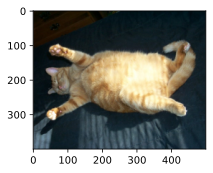

In [2]:
d2l.set_figsize()
img = d2l.Image.open('../img/cat1.jpg')
d2l.plt.imshow(img)

In [3]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    d2l.show_images(Y, num_rows, num_cols, scale=scale)

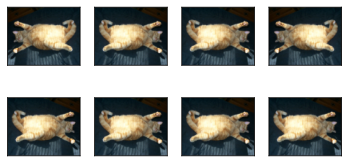

In [4]:
apply(img, torchvision.transforms.RandomHorizontalFlip())

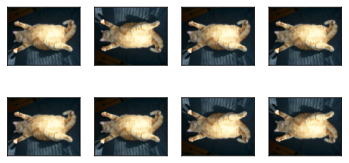

In [5]:
apply(img, torchvision.transforms.RandomVerticalFlip())

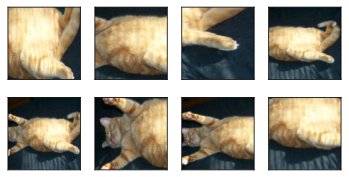

In [6]:
shape_aug = torchvision.transforms.RandomResizedCrop(
    (200, 200), scale=(0.1, 1), ratio=(0.5, 2)
)
apply(img, shape_aug)

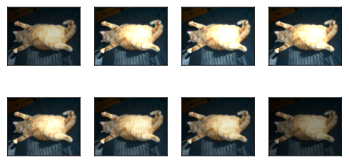

In [7]:
apply(img, torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0, saturation=0, hue=0
))

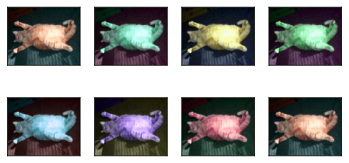

In [8]:
apply(img, torchvision.transforms.ColorJitter(
    brightness=0, contrast=0, saturation=0, hue=0.5
))

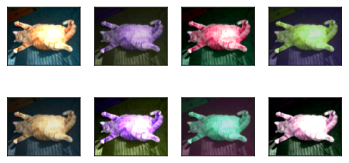

In [9]:
color_aug = torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(img, color_aug)

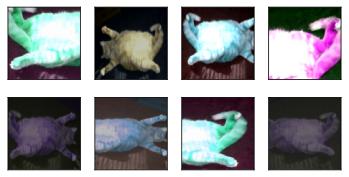

In [10]:
augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    color_aug,
    shape_aug
])
apply(img, augs)

Files already downloaded and verified


array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >], dtype=object)

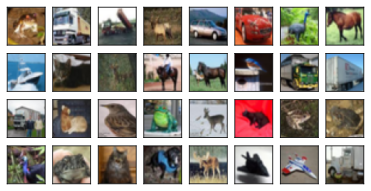

In [11]:
all_images = torchvision.datasets.CIFAR10(train=True, root="../data", download=True)
d2l.show_images([all_images[i][0] for i in range(32)], 4, 8, scale=0.8)

In [12]:
train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor()
])

test_augs = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

In [ ]:
def load_cifair10(is_train, augs, batch_size):
    datasets = torchvision.datasets.CIFAR10(root="../data", train=is_train, transform=augs, download=True)
    dataloader = torch.utils.data.DataLoader(datasets, batch_size=batch_size, shuffle=is_train, num_workers=4)
    return dataloader

In [14]:
def train_batch_ch13(net, X, y, loss, trainer, devices):
    '''用多GPU进行训练'''
    if isinstance(X, list):
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    # 这里对l进行sum()，是因为我们使用的损失函数（如nn.CrossEntropyLoss）在未设定reduction='sum'时，输出是一个batch里每个样本的loss（即一个向量）。我们希望对整个小批量的loss求和后再反向传播，使多卡或手动归约时能获得与单卡训练一致的梯度缩放。
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum
    

In [15]:
def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices=d2l.try_all_gpus()):
    timer, num_batchs = d2l.Timer(), len(train_iter)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['train loss', 'train acc', 'test acc'])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(4)
        # INSERT_YOUR_CODE
        # enumerate 是 Python 的一个内置函数，它用于在遍历可迭代对象（如列表、元组等）时，同时获取元素的索引和值。
        # 例如：for idx, value in enumerate(some_list): ... 中，idx 是索引，value 是对应的元素。
        # 在本例中，for i, (features, labels) in enumerate(train_iter): 循环中，i 是批次数的索引，(features, labels) 是从数据迭代器中取出的一个批数据。
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_ch13(net, features, labels, loss=loss, trainer=trainer, devices=devices)
            metric.add(l, acc, labels.shape[0], features.numel())
            timer.stop()
            if (i+1)%(num_batchs // 5) == 0 or i == num_batchs -1:
                animator.add(
                    epoch + (i+1) / num_batchs,
                    (metric[0]/metric[2], metric[1]/metric[3], None)
                )
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter, devices)
        animator.add(epoch+1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(devices)}')

In [16]:
batch_size, devices, net = 256, d2l.try_all_gpus(), d2l.resnet18(10, 3)

def init_weights(m):
    if type(m) in [nn.Linear, nn.Conv2d]:
        nn.init.xavier_uniform_(m.weight)

net.apply(init_weights)

def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
    train_iter = load_cifair10(True, train_augs, batch_size)
    test_iter = load_cifair10(False, test_augs, batch_size)
    loss = nn.CrossEntropyLoss(reduction='none')
    trainer = torch.optim.Adam(net.parameters(), lr)
    train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)

/Users/yw.hao/miniconda3/envs/deeplearning/lib/python3.9/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [17]:
train_with_data_aug(train_augs, test_augs, net)

Files already downloaded and verified


TypeError: __init__() got an unexpected keyword argument 'num_works'